In [1]:
# TO USE: 
#    1. Upload your recorded tone sample .wav file from the SmartAmpPro plugin.
#        Note: Optionally, upload two separate .wav files and set flags for two inputs
#        Note: Currently supports 32 Bit FLoating Point Wav, or 16 Bit PCM;
#                Using 16 Bit PCM (CD quality) allows for smaller .wav files
#    2. Select a runtime (GPU recommended)
#    3. Change the "in_file" variable to match your uploaded file. 
#        Note: If two .wav files used, set "out_file" to match uploaded file
#    4 Change the "name" file to the desired model name
#    5. Click "Runtime" then "Run All"
#
#     Note: Tested on CPU and GPU runtimes.
#     Note: Uses MSE for loss calculation instead of Error to Signal with Pre-emphasis filter

# EDIT THIS SECTION FOR USER INPUTS ###########################################
#
name = 'my_model'
in_file = '/content/drive/My Drive/dsr_project/data/sound_with_reverb/SIHarvardWordListsFemale_with_reverb.wav'

# If using two mono .wav files, enter uploaded out_file here
# If using a single stereo .wav file recorded from SmartAmpPro,
#    ensure out_file=''
out_file = '/content/drive/My Drive/dsr_project/data/HarvardWordList/SIHarvardWordListsFemale.wav'

## Training Parameters
epochs = 3  # Increase epochs to try extended training to improve model results 
learning_rate = 0.001  # Agressiveness of training
hidden_units = 24     # Number of units in LSTM layer to train

input_size = 120 # Using input_size greater than 140 will not work in SmartAmpPro

batch_size = 4096 # Number of samples to train at a time
test_size = 0.2 # Portion of input data to use in testing (.2 = 20%)
###############################################################################

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.activations import tanh, elu, relu
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

import os
from scipy import signal
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import math
import h5py

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
if not os.path.exists('models/'+name):
    os.makedirs('models/'+name)
else:
    print("A model with the same name already exists. Please choose a new name.")
    exit

A model with the same name already exists. Please choose a new name.


In [3]:
class WindowArray(Sequence):
        
    def __init__(self, x, y, window_len, batch_size=32):
        self.x = x
        self.y = y[window_len-1:] 
        self.window_len = window_len
        self.batch_size = batch_size
        
    def __len__(self):
        return (len(self.x) - self.window_len +1) // self.batch_size
    
    def __getitem__(self, index):
        x_out = np.stack([self.x[idx: idx+self.window_len] for idx in range(index*self.batch_size, (index+1)*self.batch_size)])
        y_out = self.y[index*self.batch_size:(index+1)*self.batch_size]
        return x_out, y_out

In [ ]:
def save_wav(name, data):
    wavfile.write(name, 8000, data.flatten().astype(np.float32))

def normalize(data):
    data_max = max(data)
    data_min = min(data)
    data_norm = max(data_max,abs(data_min))
    return data / data_norm


'''This is a similar Tensorflow/Keras implementation of the LSTM model from the paper:
    "Real-Time Guitar Amplifier Emulation with Deep Learning"
    https://www.mdpi.com/2076-3417/10/3/766/htm

    Uses a stack of two 1-D Convolutional layers, followed by LSTM, followed by 
    a Dense (fully connected) layer. Three preset training modes are available, 
    with further customization by editing the code. A Sequential tf.keras model 
    is implemented here.
'''
# Preset parameters specifically for running in SmartAmpPro
conv1d_strides = 12
conv1d_1_strides = 12   
conv1d_filters = 4

conv1d_KS = conv1d_strides 
conv1d_1_KS = conv1d_1_strides

# Create Sequential Model ###########################################
clear_session()
model = Sequential()
model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same',input_shape=(input_size,1)))
model.add(Conv1D(conv1d_filters, 12,strides=conv1d_strides, activation=None, padding='same'))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation=None))
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mse'])
model.summary()

# Load and Preprocess Data ###########################################
in_rate, stereo_data = wavfile.read(in_file)

# If a second wav file is provided, assume each file is mono and load data
if out_file != "":
    out_rate, out_data = wavfile.read(out_file)
    #out_data = out_data.T[0]
    in_data = stereo_data
# Else, use the stereo wav file channel 1 and channel 2 for training data
else:
    in_data = stereo_data.T[0]
    out_data = stereo_data.T[1]

X_all = in_data.astype(np.float32).flatten()  
X_all = normalize(X_all).reshape(len(X_all),1)   
y_all = out_data.astype(np.float32).flatten() 
y_all = normalize(y_all).reshape(len(y_all),1)

train_examples = int(len(X_all)*0.8)
train_arr = WindowArray(X_all[:train_examples], y_all[:train_examples], input_size, batch_size=batch_size)
val_arr = WindowArray(X_all[train_examples:], y_all[train_examples:], input_size, batch_size=batch_size)

# Train Model ###################################################
history = model.fit(train_arr, validation_data=val_arr, epochs=epochs, shuffle=True)    
#model.save('models/'+name+'/'+name+'.h5')

# Run Prediction #################################################
print("Running prediction..")

# Get the last 20% of the wav data to run prediction and plot results
y_the_rest, y_last_part = np.split(y_all, [int(len(y_all)*.8)])
x_the_rest, x_last_part = np.split(X_all, [int(len(X_all)*.8)])
y_test = y_last_part[input_size-1:] 
test_arr = WindowArray(x_last_part, y_last_part, input_size, batch_size = batch_size)

prediction = model.predict(test_arr)

save_wav('/content/drive/My Drive/dsr_project/data/sound_with_reverb/y_pred.wav', prediction)
save_wav('/content/drive/My Drive/dsr_project/data/sound_with_reverb/y_test.wav', y_last_part)
save_wav('/content/drive/My Drive/dsr_project/data/sound_with_reverb/x_test.wav', x_last_part)
#save_wav('/content/drive/My Drive/dsr_project/data/sound_with_reverb/y_test.wav', y_test)

# Add additional data to the saved model (like input_size)
#filename = 'models/'+name+'/'+name+'.h5'
#f = h5py.File(filename, 'a')
#grp = f.create_group("info")
#dset = grp.create_dataset("input_size", (1,), dtype='int16')
#dset[0] = input_size
#dset2 = grp.create_dataset("conv1d_stride", (1,), dtype='int16')
#dset3 = grp.create_dataset("conv1d_1_stride", (1,), dtype='int16')
#dset[0] = input_size
#dset2[0] = conv1d_strides
#dset3[0] = conv1d_1_strides
#f.close()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 4)             52        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 4)              196       
                                                                 
 lstm (LSTM)                 (None, 24)                2784      
                                                                 
 dense (Dense)               (None, 1)                 25        
                                                                 
Total params: 3,057
Trainable params: 3,057
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: WavFileWarning: Chunk (non-data) not understood, skipping it.


Epoch 1/3
443/443 [==============================] - 9s 15ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 2/3
443/443 [==============================] - 6s 14ms/step - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 3/3
151/443 [=========>....................] - ETA: 3s - loss: 0.0060 - mse: 0.0060

In [20]:
print(y_last_part.shape)
print(x_last_part.shape)

(2506056, 1)
(454614, 1)


In [8]:
save_wav('/content/drive/My Drive/dsr_project/data/sound_with_reverb/y_pred.wav', prediction)

array([[ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       ...,
       [ 0.0000000e+00],
       [-3.2323755e-05],
       [ 0.0000000e+00]], dtype=float32)

In [5]:
signal1 = prediction
signal2 = y_test
signal3 = x_last_part

error_list_0 = []
for s1, s2 in zip(signal1, signal2):
  error_list_0.append(abs(s2 - s1))

error_list_1 = []
for s2, s3 in zip(signal2, signal3):
  error_list_1.append(abs(s3 - s2))

print(np.sum(error_list_0)/len(error_list_0))
print(np.sum(error_list_1)/len(error_list_1))

0.04002610553394664
0.060774733998238066


In [9]:
# Generate json model ################################
import json
filename = 'models/'+name+'/'+ name +'.h5'
json_filename = 'models/'+name+'/'+ name
f = h5py.File(filename, 'r')

# Load the model data
data = {}
for layer in f["model_weights"].keys():
    if layer not in data.keys():
        data[layer] = {}
    for item in f["model_weights"][layer][layer]:
        if item not in data[layer].keys():
            data[layer][item] = {}
            try:
                data[layer][item] = f["model_weights"][layer][layer][item][:].tolist()
            except:
                data[layer]["kernel:0"] = f["model_weights"][layer][layer][item]["kernel:0"][:].tolist()
                data[layer]["bias:0"] = f["model_weights"][layer][layer][item]["bias:0"][:].tolist()
        else:
            try:
                data[layer][item] = f["model_weights"][layer][layer][item][:].tolist()
            except:
                data[layer]["kernel:0"] = f["model_weights"][layer][layer][item]["kernel:0"][:].tolist()
                data[layer]["bias:0"] = f["model_weights"][layer][layer][item]["bias:0"][:].tolist()

input_size = f["info"]["input_size"][0]
conv1d_strides = f["info"]["conv1d_stride"][0]
conv1d_1_strides = f["info"]["conv1d_1_stride"][0]
data['input_size'] = int(input_size)
print("input_size: ",input_size)
data['conv1d_stride'] = int(conv1d_strides)
data['conv1d_1_stride'] = int(conv1d_1_strides)
f.close()

with open(json_filename + ".json", 'w') as outfile:
    json.dump(data, outfile)
print("SmartAmpPro model generated: ", json_filename + ".json")

KeyError: ignored

Plotting results..


IndexError: ignored

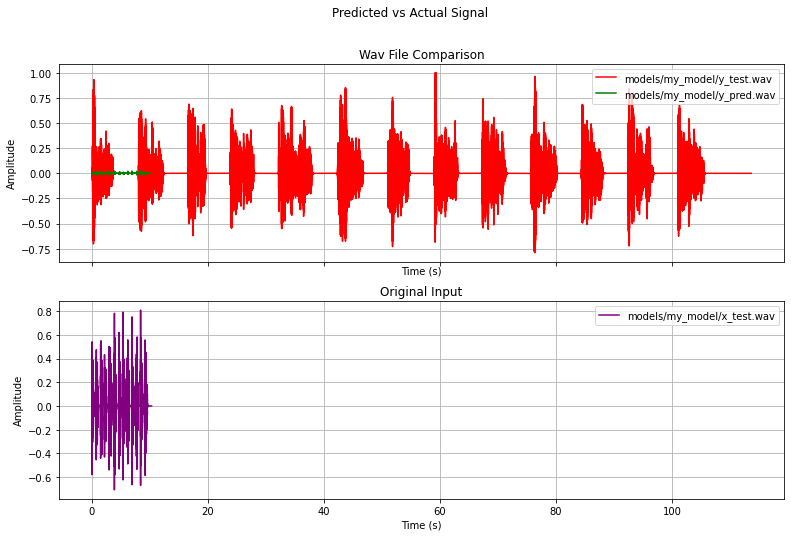

In [10]:
# Model Evaluation and Plotting

def read_wave(wav_file):
    # Extract Audio and framerate from Wav File
    fs, signal = wavfile.read(wav_file)
    return signal, fs


def analyze_pred_vs_actual(output_wav, pred_wav, input_wav, model_name, show_plots, path):
    """Generate plots to analyze the predicted signal vs the actual
    signal.

    Inputs:
        output_wav : The actual signal, by default will use y_test.wav from the test.py output
        pred_wav : The predicted signal, by default will use y_pred.wav from the test.py output
        input_wav : The pre effect signal, by default will use x_test.wav from the test.py output
        model_name : Used to add the model name to the plot .png filename
        path   :   The save path for generated .png figures
        show_plots : Default is 1 to show plots, 0 to only generate .png files and suppress plots

    """

    # Read the input wav file
    signal3, fs3 = read_wave(input_wav)

    # Read the output wav file
    signal1, fs = read_wave(output_wav)

    Time = np.linspace(0, len(signal1) / fs, num=len(signal1))
    fig, (ax1, ax3) = plt.subplots(2, sharex=True, figsize=(13, 8))
    fig.suptitle("Predicted vs Actual Signal")
    ax1.plot(Time, signal1, label=output_wav, color="red")

    # Read the predicted wav file
    signal2, fs2 = read_wave(pred_wav)

    Time2 = np.linspace(0, len(signal2) / fs2, num=len(signal2))
    ax1.plot(Time2, signal2, label=pred_wav, color="green")
    ax1.legend(loc="upper right")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.set_title("Wav File Comparison")
    ax1.grid("on")

    error_list = []
    for s1, s2 in zip(signal1, signal2):
        error_list.append(abs(s2 - s1))


    # Plot the original signal
    Time3 = np.linspace(0, len(signal3) / fs3, num=len(signal3))
    ax3.plot(Time3, signal3, label=input_wav, color="purple")
    ax3.legend(loc="upper right")
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Amplitude")
    ax3.set_title("Original Input")
    ax3.grid("on")

    # Save the plot
    plt.savefig(path+'/'+model_name + "_signal_comparison.png", bbox_inches="tight")
    # Create a zoomed in plot of 0.01 seconds centered at the max input signal value
    sig_temp = signal1.tolist()
    plt.axis(
        [
            Time3[sig_temp.index((max(sig_temp)))] - 0.005,
            Time3[sig_temp.index((max(sig_temp)))] + 0.005,
            min(signal2),
            max(signal2),
        ]
    )
   
    plt.savefig(path+'/'+model_name + "_Detail_signal_comparison.png", bbox_inches="tight")
    plt.show() # Uncomment this line to show Detail plot
    # Reset the axis
    plt.axis([0, Time3[-1], min(signal2), max(signal2)])


print("Plotting results..")


analyze_pred_vs_actual('models/'+name+'/y_test.wav',
                       'models/'+name+'/y_pred.wav', 
                       'models/'+name+'/x_test.wav',
                       name,
                       1,
                       'models/'+name)